# QUESTION 1

In [109]:
import pandas as pd
import re

# ---------------------------
# Raw string data
# ---------------------------
data_string = """
Manufactured In-House	
Fixed Cost	$49,000
Unit Variable Cost	$125
Purchased from Supplier	
Unit Cost	$170
"""

# ---------------------------
# Extract numeric values from the text
# ---------------------------

# Helper function to extract the first number from a line
def extract_number(pattern, text):
    match = re.search(pattern, text)
    if match:
        return float(match.group(1).replace(",", ""))
    else:
        raise ValueError(f"Pattern not found: {pattern}")

fixed_cost_in_house = extract_number(r"Fixed Cost\s*\$(\d[\d,]*)", data_string)
unit_variable_cost_in_house = extract_number(r"Unit Variable Cost\s*\$(\d+)", data_string)
unit_cost_outsource = extract_number(r"Unit Cost\s*\$(\d+)", data_string)

# Levels of demand
demand_levels = [800, 1000, 1200, 1300]

# Calculate costs
in_house_costs = []
outsource_costs = []

for demand in demand_levels:
    in_house_total_cost = fixed_cost_in_house + (unit_variable_cost_in_house * demand)
    outsource_total_cost = unit_cost_outsource * demand

    in_house_costs.append(in_house_total_cost)
    outsource_costs.append(outsource_total_cost)

# Create the payoff table
payoff_table = pd.DataFrame({
    "Demand": demand_levels,
    "Manufacture": in_house_costs,
    "Outsource": outsource_costs
})

# Output
print(payoff_table)


   Demand  Manufacture  Outsource
0     800    149000.00  136000.00
1    1000    174000.00  170000.00
2    1200    199000.00  204000.00
3    1300    211500.00  221000.00


# Question 2

In [77]:
import re
import pandas as pd
from typing import Tuple, List
import warnings

warnings.filterwarnings("ignore")
def parse_payoff_string(table_text: str) -> pd.DataFrame:
    """
    Parse a payoff table from a multiline string.
    Expects first non-empty line to contain the header (state labels / demands),
    and following lines to contain alternative names and numeric costs (optionally prefixed by $ and commas).
    Returns a DataFrame with alternatives as index and states as columns (numeric).
    """
    lines = [ln.strip() for ln in table_text.splitlines() if ln.strip()]
    if not lines:
        raise ValueError("Empty table text.")

    # Header: capture numeric state labels (like demands)
    header_line = lines[0]
    header_nums = re.findall(r"\d[\d,]*", header_line)  # captures numbers like 1,000 or 800
    if not header_nums:
        raise ValueError("Header must contain numeric state labels (e.g. demand levels).")
    states = [int(h.replace(",", "")) for h in header_nums]

    data = {}
    alternatives = []
    for row in lines[1:]:
        # Extract numeric entries (costs) from the row
        raw_numbers = re.findall(r"\$?[\d,]+", row)
        if len(raw_numbers) != len(states):
            # try a fallback: maybe numbers are plain integers without commas/$
            raw_numbers = re.findall(r"\d+(?:,\d+)?", row)
        if len(raw_numbers) != len(states):
            raise ValueError(f"Row does not have exactly {len(states)} numeric entries: {row}")

        values = [int(r.replace("$", "").replace(",", "")) for r in raw_numbers]

        # Extract alternative name by removing the numeric tokens from the row
        name = re.sub(r"\$?[\d,]+", " ", row).strip()
        name = re.sub(r"\s{2,}", " ", name)  # collapse multiple spaces
        alternatives.append(name)
        data[name] = values

    df = pd.DataFrame(data, index=states).T  # rows=alternatives, cols=states
    df.columns = [str(c) for c in df.columns]  # make column labels strings (demand levels)
    return df

def aggressive_strategy(df: pd.DataFrame) -> Tuple[List[str], int]:
    """
    Aggressive (optimistic) strategy for costs:
    choose alternative with smallest *minimum* cost across states.
    Returns list of chosen alternatives and the minimum cost value.
    """
    best_cases = df.min(axis=1)
    best_value = best_cases.min()
    choices = best_cases[best_cases == best_value].index.tolist()
    return choices, int(best_value)

def conservative_strategy(df: pd.DataFrame) -> Tuple[List[str], int]:
    """
    Conservative (pessimistic) strategy for costs:
    choose alternative with smallest *maximum* cost across states (minimax).
    Returns list of chosen alternatives and that max cost value.
    """
    worst_cases = df.max(axis=1)
    best_worst = worst_cases.min()
    choices = worst_cases[worst_cases == best_worst].index.tolist()
    return choices, int(best_worst)

def opportunity_loss_strategy(df: pd.DataFrame) -> Tuple[List[str], int, pd.DataFrame]:
    """
    Opportunity-loss (minimax regret) strategy for costs:
    - compute regret matrix: regret = cost - best_cost_in_state
    - compute max regret per alternative
    - choose alternative with smallest max regret
    Returns chosen alternatives, numeric regret value, and the regret DataFrame.
    """
    best_per_state = df.min(axis=0)
    regrets = df.subtract(best_per_state, axis=1)
    max_regrets = regrets.max(axis=1)
    best_regret_value = int(max_regrets.min())
    choices = max_regrets[max_regrets == best_regret_value].index.tolist()
    return choices, best_regret_value, regrets

def format_currency(x: int) -> str:
    return f"${x:,}"

def analyze_payoff(input_table_string: str) -> None:
    df = parse_payoff_string(input_table_string)
    print("Parsed payoff table (costs):")
    print(df.to_string())
    print()

    # Aggressive
    ag_choices, ag_value = aggressive_strategy(df)
    print("AGGRESSIVE (optimistic) strategy:")
    print(f"  Choice(s): {', '.join(ag_choices)}")
    print(f"  Reason: has the lowest minimum cost of {format_currency(ag_value)}")
    print()

    # Conservative
    con_choices, con_value = conservative_strategy(df)
    print("CONSERVATIVE (pessimistic) strategy:")
    print(f"  Choice(s): {', '.join(con_choices)}")
    print(f"  Reason: has the lowest maximum cost of {format_currency(con_value)}")
    print()

    # Opportunity loss
    ol_choices, ol_value, regrets = opportunity_loss_strategy(df)
    print("OPPORTUNITY-LOSS (minimax regret) strategy:")
    print(f"  Choice(s): {', '.join(ol_choices)}")
    print(f"  Reason: has the lowest maximum opportunity loss of {format_currency(ol_value)}")
    print()
    # print("Regret (opportunity-loss) matrix:")
    # # format regrets with commas
    # print(regrets.applymap(lambda v: format_currency(int(v))).to_string())
    # print()

# -------------------------
# Example usage with the provided table
# -------------------------
input_table_string = """
Demand	800	1,000	1,200	1,400
In‐House	$167,000	$200,000	$233,000	$266,000
Outsource	$156,000	$195,000	$234,000	$273,000
"""

if __name__ == "__main__":
    analyze_payoff(input_table_string)


Parsed payoff table (costs):
              800    1000    1200    1400
In‐House   167000  200000  233000  266000
Outsource  156000  195000  234000  273000

AGGRESSIVE (optimistic) strategy:
  Choice(s): Outsource
  Reason: has the lowest minimum cost of $156,000

CONSERVATIVE (pessimistic) strategy:
  Choice(s): In‐House
  Reason: has the lowest maximum cost of $266,000

OPPORTUNITY-LOSS (minimax regret) strategy:
  Choice(s): Outsource
  Reason: has the lowest maximum opportunity loss of $7,000



# Question 3

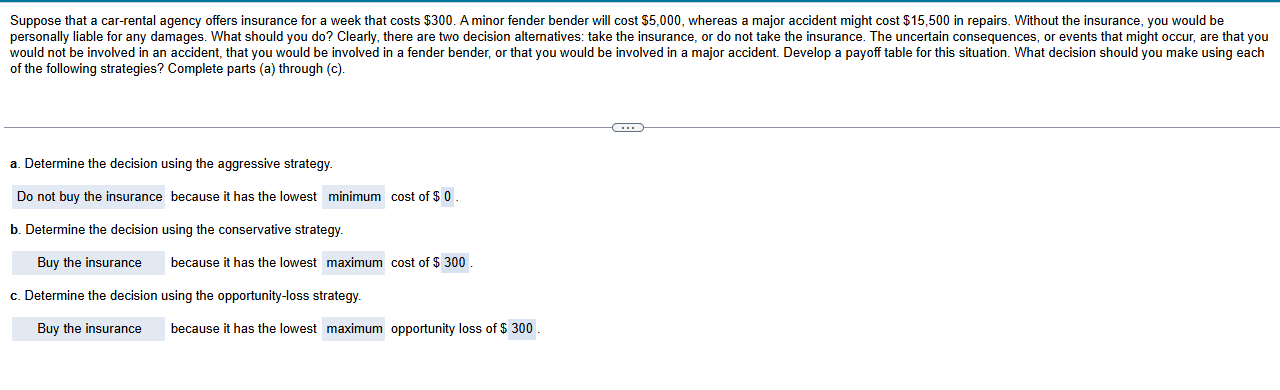

 # Question 4

In [104]:
#!/usr/bin/env python3
"""
Combined Parts A, B, and C:
 - Parses a payoff table from a text block
 - Computes population (ddof=0) and sample (ddof=1) standard deviations per decision
 - Prints results and fills the Part C multiple-choice answer using population std (ddof=0)
"""
import re
import pandas as pd
import numpy as np
from textwrap import dedent

table_text = dedent("""\
    Slight Decline    20% Decline    40% Decline
Stay in Carmel	$1,055,000	$855,000	$805,000
Move to Wisconsin	$1,130,000	$990,000	$750,000
""")

def extract_rows(table_text):
    lines = [ln.strip() for ln in table_text.splitlines() if ln.strip()]
    header = lines[0]
    states = [s.strip() for s in re.split(r"\s{2,}", header) if s.strip()]
    rows = {}
    for row in lines[1:]:
        parts = re.findall(r"([A-Za-z0-9\s\-\&]+?)\s+(\$?[\d,]+)\s+(\$?[\d,]+)\s+(\$?[\d,]+)$", row)
        if parts:
            name, v1, v2, v3 = parts[0]
            numeric_vals = [int(v.replace("$","").replace(",","")) for v in (v1, v2, v3)]
            rows[name.strip()] = numeric_vals
        else:
            nums = re.findall(r"\$?[\d,]+", row)
            name = re.sub(r"\$?[\d,]+", " ", row).strip()
            numeric_vals = [int(v.replace("$","").replace(",","")) for v in nums]
            rows[name] = numeric_vals
    df = pd.DataFrame(rows, index=states).T
    return df

def main():
    df = extract_rows(table_text)
    # print("Parsed payoff table (dollars):")
    # print(df.to_string())
    # print()

    # Population and sample standard deviations
    std_pop = df.std(axis=1, ddof=0).round(0).astype(int)
    std_sample = df.std(axis=1, ddof=1).round(0).astype(int)

    results = pd.DataFrame({
        "Population Std Dev (ddof=0)": std_pop,
        "Sample Std Dev (ddof=1)": std_sample
    })
    # print("Standard deviation of payoffs for each decision (rounded to nearest dollar):")
    # print(results.to_string())
    # print()

    # Numeric summary
    for name in df.index:
        print(f" - {name}: population std = ${std_pop[name]:,}, sample std = ${std_sample[name]:,}")
    print()

    # Part C: interpretation using population std (ddof=0)
    # Prompt labels: [A] move to Wisconsin  [B] stay in Carmel
    pop_move = std_pop['Move to Wisconsin']
    pop_stay = std_pop['Stay in Carmel']

    if pop_move > pop_stay:
        # Move to Wisconsin is riskier
        print("Part C (filled):")
        print("The decision to [A] move to Wisconsin is riskier because the standard deviation of its payoffs is GREATER THAN the standard deviation of the payoffs of [B] staying in Carmel.")
    elif pop_move < pop_stay:
        # Stay in Carmel is riskier
        print("Part C (filled):")
        print("The decision to [B] stay in Carmel is riskier because the standard deviation of its payoffs is GREATER THAN the standard deviation of the payoffs of [A] moving to Wisconsin.")
    else:
        print("Part C (filled):")
        print("The two decisions have the same standard deviation, so neither is riskier by this measure.")

    print()

if __name__ == "__main__":
    main()


 - Stay in Carmel: population std = $108,012, sample std = $132,288
 - Move to Wisconsin: population std = $156,915, sample std = $192,180

Part C (filled):
The decision to [A] move to Wisconsin is riskier because the standard deviation of its payoffs is GREATER THAN the standard deviation of the payoffs of [B] staying in Carmel.



# Question 5 

In [114]:
# expected_value_decision.py
# Computes expected costs and chooses the best decision (lowest expected cost).

probabilities = [0.20, 0.45, 0.35]   # [Slight decline, 20% decline, 40% decline]

# Payoff table = total costs under each scenario (dollars)
costs = {
    "Stay in Carmel":   [1_100_000, 830_000, 850_000],
    "Move to Wisconsin": [1_200_000, 900_000, 750_000]
}

def expected_value(costs_list, probs):
    """Compute expected value (expected cost) given costs list and matching probs."""
    return sum(c * p for c, p in zip(costs_list, probs))

def main():
    ev = {}
    for decision, vals in costs.items():
        ev_val = expected_value(vals, probabilities)
        ev[decision] = round(ev_val)   # round to nearest dollar

    # Print results
    for decision, val in ev.items():
        print(f"{decision}: Expected cost = ${val:,}")

    # Choose best decision (minimum expected cost)
    best_decision = min(ev, key=ev.get)
    best_value = ev[best_decision]
    print()
    print("Best expected-value decision:")
    print(f" -> {best_decision} with expected cost ${best_value:,}")

    # Fill-in the multiple-choice blanks as required
    # Labels used in the problem: [A] stay in Carmel  [B] move to Wisconsin
    if best_decision == "Stay in Carmel":
        choice_letter = "[A] stay in Carmel"
        why = "[A] lowest"
        dollar_answer = f"${best_value:,}"
    else:
        choice_letter = "[B] move to Wisconsin"
        why = "[B] lowest"
        dollar_answer = f"${best_value:,}"

    print()
    print("Fill-in answers:")
    print(f"The best expected value decision is to {choice_letter}")
    print(f"because it results in the {why} expected value of {dollar_answer}.")

if __name__ == "__main__":
    main()


Stay in Carmel: Expected cost = $891,000
Move to Wisconsin: Expected cost = $907,500

Best expected-value decision:
 -> Stay in Carmel with expected cost $891,000

Fill-in answers:
The best expected value decision is to [A] stay in Carmel
because it results in the [A] lowest expected value of $891,000.


Question 6

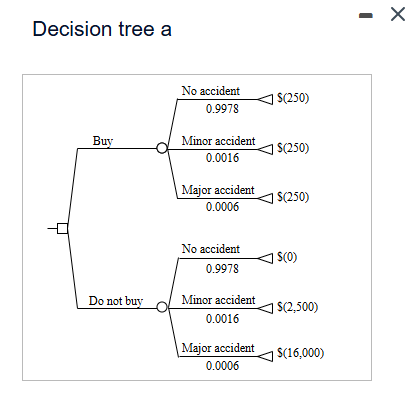

In [107]:
# Car rental insurance decision EV calculator

prob_major = 0.0006    # 0.06%
prob_fender = 0.0012   # 0.16%
prob_none = 1 - (prob_major + prob_fender)

# Costs if you do NOT buy insurance
cost_none_no_ins = 0.0
cost_fender_no_ins = 2000.0
cost_major_no_ins = 16500.0

# Insurance cost (covers repairs fully)
insurance_cost = 100.0

# Expected cost if you BUY insurance: you pay the premium regardless
expected_cost_buy = insurance_cost

# Expected cost if you DON'T buy insurance: weighted average of repair costs
expected_cost_no_buy = (
    prob_none * cost_none_no_ins
    + prob_fender * cost_fender_no_ins
    + prob_major * cost_major_no_ins
)

# Print results (rounded to cents)
print(f"Probabilities: no accident = {prob_none:.6f}, fender = {prob_fender:.6f}, major = {prob_major:.6f}")
print(f"Expected cost if BUY insurance (rollback value for buying): ${expected_cost_buy:,.2f}")
print(f"Expected cost if DO NOT buy insurance: ${expected_cost_no_buy:,.2f}")

if expected_cost_buy < expected_cost_no_buy:
    print("Decision: BUY insurance (lower expected cost).")
elif expected_cost_buy > expected_cost_no_buy:
    print("Decision: DO NOT buy insurance (lower expected cost).")
else:
    print("Both choices have the same expected cost.")


Probabilities: no accident = 0.998200, fender = 0.001200, major = 0.000600
Expected cost if BUY insurance (rollback value for buying): $100.00
Expected cost if DO NOT buy insurance: $12.30
Decision: DO NOT buy insurance (lower expected cost).


# Question 7

# For Dynamic Values

Dynamic Optimization Results
 P_harsh  Optimal_Q  Expected_Profit
    0.20        350          4115.00
    0.40       2500          9206.00
    0.60       3000         17758.00
    0.80       3000         26815.00


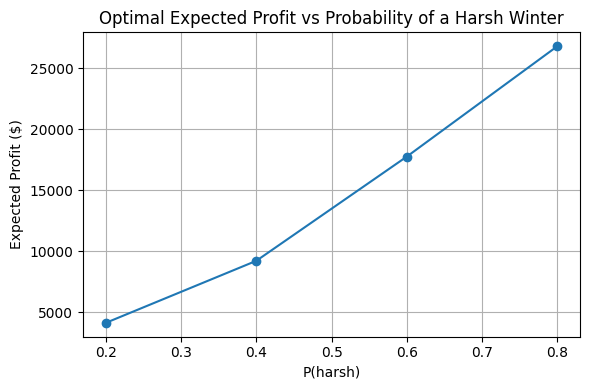

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Cost & price parameters
c = 15.0       # cost per unit
p = 29.95      # selling price
v = 10.0       # salvage value

# Demand distributions
mild_demands = {250:0.5, 300:0.4, 350:0.1}
harsh_demands = {1500:0.2, 2500:0.3, 3000:0.5}

# Expected profit function
def expected_profit(Q, P_h):
    probs = {}
    for d, pr in mild_demands.items():
        probs[d] = probs.get(d, 0) + (1-P_h) * pr
    for d, pr in harsh_demands.items():
        probs[d] = probs.get(d, 0) + P_h * pr
    
    ep = 0.0
    for d, pr in probs.items():
        sold = min(Q, d)
        leftover = max(Q - d, 0)
        profit = p * sold + v * leftover - c * Q
        ep += pr * profit
    return ep

# Search space for Q (0 to max harsh demand)
Q_range = range(0, 3001)

# Probability scenarios
P_values = [0.2, 0.4, 0.6, 0.8]

results = []

for P in P_values:
    best_Q = None
    best_profit = -1e12
    
    for Q in Q_range:
        ep = expected_profit(Q, P)
        if ep > best_profit:
            best_profit = ep
            best_Q = Q
    
    results.append({
        'P_harsh': P,
        'Optimal_Q': best_Q,
        'Expected_Profit': round(best_profit, 0)
    })

df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(6,4))
plt.plot(df['P_harsh'], df['Expected_Profit'], marker='o')
plt.title('Optimal Expected Profit vs Probability of a Harsh Winter')
plt.xlabel('P(harsh)')
plt.ylabel('Expected Profit ($)')
plt.grid(True)
plt.tight_layout()

# Display results
print("Dynamic Optimization Results")
print(df.to_string(index=False))

plt.show()


# For static Values 

Sensitivity Analysis Results
 P_harsh  Optimal_Q  Expected_Profit
    0.20        400          4065.00
    0.40       2600          9105.00
    0.60       3000         17758.00
    0.80       3000         26815.00



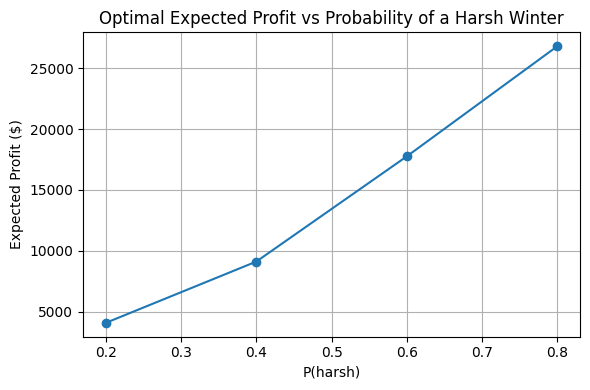

' P_harsh  Optimal_Q  Expected_Profit\n    0.20        400          4065.00\n    0.40       2600          9105.00\n    0.60       3000         17758.00\n    0.80       3000         26815.00'

In [112]:
# Compute expected profits for given optimal Qs and plot results
import matplotlib.pyplot as plt
import pandas as pd

# Cost & price parameters
c = 15.0       # cost per unit
p = 29.95      # selling price
v = 10.0       # salvage value

# Demand distributions
mild_demands = {250:0.5, 300:0.4, 350:0.1}
harsh_demands = {1500:0.2, 2500:0.3, 3000:0.5}

def expected_profit(Q, P_h):
    probs = {}
    for d,pr in mild_demands.items():
        probs[d] = probs.get(d,0) + (1-P_h)*pr
    for d,pr in harsh_demands.items():
        probs[d] = probs.get(d,0) + P_h*pr
    ep=0.0
    for d,pr in probs.items():
        sold = min(Q,d)
        leftover = max(Q-d,0)
        profit = p*sold + v*leftover - c*Q
        ep += pr*profit
    return ep

P_values=[0.2,0.4,0.6,0.8]
Qs=[400,2600,3000,3000]

results = []
for P,Q in zip(P_values,Qs):
    ep = expected_profit(Q,P)
    results.append({'P_harsh':P, 'Optimal_Q':Q, 'Expected_Profit':round(ep,0)})

df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(6,4))
plt.plot(df['P_harsh'], df['Expected_Profit'], marker='o')
plt.title('Optimal Expected Profit vs Probability of a Harsh Winter')
plt.xlabel('P(harsh)')
plt.ylabel('Expected Profit ($)')
plt.grid(True)
plt.tight_layout()

# Display dataframe and plot
def display_dataframe_to_user(title: str, df: pd.DataFrame):
    print(title)
    print(df.to_string(index=False))
    print()
display_dataframe_to_user("Sensitivity Analysis Results", df)

plt.show()

# Also print values for quick reference
df.to_string(index=False)


# Question 8

In [110]:
# Ski ordering payoff table + EVPI + Part C
import numpy as np
import pandas as pd

# Problem data
demands = np.array([125, 150, 175, 200, 225], dtype=float)
probs = np.array([0.13, 0.33, 0.32, 0.17, 0.05], dtype=float)
orders = np.array([140, 160, 180, 200, 220], dtype=float)

purchase_cost = 175.0
sell_price = 300.0
salvage_price = 100.0

# Build payoff matrix (rows = orders, columns = demands)
payoff = np.zeros((len(orders), len(demands)), dtype=float)
for i, Q in enumerate(orders):
    for j, D in enumerate(demands):
        sold = min(Q, D)
        leftover = max(0.0, Q - D)
        revenue = sold * sell_price + leftover * salvage_price
        cost = Q * purchase_cost
        profit = revenue - cost
        payoff[i, j] = profit

# DataFrame for display
df = pd.DataFrame(payoff, index=[int(q) for q in orders], columns=[int(d) for d in demands])
df["Expected Profit"] = payoff.dot(probs)

# Best decision without information
best_idx = int(np.argmax(df["Expected Profit"].values))
best_order = int(orders[best_idx])
best_ev = df["Expected Profit"].values[best_idx]

# EV with perfect information and EVPI
best_profit_each_demand = payoff.max(axis=0)
ev_with_perfect_info = np.dot(best_profit_each_demand, probs)
evpi = ev_with_perfect_info - best_ev

# PART C
# 1) Expected demand (exact)
expected_demand = float(np.dot(demands, probs))

# 2) Expected profit if ordering Q = expected_demand (use Q exactly, even if not multiple of 20)
Q_exp = expected_demand
profits_Qexp = []
for D in demands:
    sold = min(Q_exp, D)
    leftover = max(0.0, Q_exp - D)
    revenue = sold * sell_price + leftover * salvage_price
    cost = Q_exp * purchase_cost
    profit = revenue - cost
    profits_Qexp.append(profit)
expected_profit_Qexp = float(np.dot(profits_Qexp, probs))

# 3) Comparison to expected-value decision
if expected_profit_Qexp == best_ev:
    comparison = "the same as"
elif expected_profit_Qexp > best_ev:
    comparison = "better than"
else:
    comparison = "worse than"

# Print results
pd.set_option("display.float_format", "{:.2f}".format)
print("Payoff table (profits). Rows = order size, Columns = demand:")
print(df)
print()
print("Part B (EVPI):")
print(f"  Best order without info: {best_order} pairs with Expected Profit = ${best_ev:.2f}")
# print(f"  EV with perfect info = ${ev_with_perfect_info:.2f}")
print(f"  EVPI = ${evpi:.2f}")
print()
print("Part C:")
print(f"  Expected demand = {expected_demand}")  # exact/unrounded
print(f"  Expected profit when ordering expected demand (Q = {expected_demand}) = ${expected_profit_Qexp}")  # exact/unrounded
print(f"  This result is {comparison} the expected-value decision.")


Payoff table (profits). Rows = order size, Columns = demand:
         125      150      175      200      225  Expected Profit
140 14500.00 17500.00 17500.00 17500.00 17500.00         17110.00
160 13000.00 18000.00 20000.00 20000.00 20000.00         18430.00
180 11500.00 16500.00 21500.00 22500.00 22500.00         18770.00
200 10000.00 15000.00 20000.00 25000.00 25000.00         18150.00
220  8500.00 13500.00 18500.00 23500.00 27500.00         16850.00

Part B (EVPI):
  Best order without info: 180 pairs with Expected Profit = $18770.00
  EVPI = $1560.00

Part C:
  Expected demand = 167.0
  Expected profit when ordering expected demand (Q = 167.0) = $18661.0
  This result is worse than the expected-value decision.


# Question 9

In [113]:
# Bayes Rule Problem for Firm X and Firm Y

# Given probabilities
P_Y_bids = 0.80                      # Probability Firm Y bids
P_X_wins_given_Y = 0.30              # Probability X wins if Y bids
P_X_wins_given_notY = 0.60           # Probability X wins if Y does not bid
P_Y_not = 1 - P_Y_bids               # Probability Y does NOT bid
# Total probability Firm X wins the bid (Law of Total Probability)
P_X_wins = (P_X_wins_given_Y * P_Y_bids) + \
           (P_X_wins_given_notY * P_Y_not)

# Bayes rule: P(Y bid | X wins)
P_Y_bids_given_Xwins = (P_X_wins_given_Y * P_Y_bids) / P_X_wins

print("Probability Firm X wins the bid:", round(P_X_wins, 2))
print("Probability Firm Y bid given X wins:", round(P_Y_bids_given_Xwins, 2))


Probability Firm X wins the bid: 0.36
Probability Firm Y bid given X wins: 0.67


# Question 10

In [ ]:
# ski_insurance_utility.py
# Compute expected utilities and recommended decision for candidate utility mappings

p_major = 0.0005   # 0.05%
p_fender = 0.0016  # 0.18%
p_none = 1 - p_major - p_fender

# Candidate utility mappings (dictionaries: payoff -> utility)
# Payoff keys: 0 (no loss), -100 (buy insurance cost), -3200, -18000
A = {0: 1.0000, -100: 0.988, -3200: 0.733, -18000: 0.0}
B = {0: 1.0000, -100: 0.994, -3200: 0.822, -18000: 0.0}
C = {0: 0.0000, -100: 0.9111, -3200: 0.9999, -18000: 1.0000}  # nonsensical (increasing utility with loss)
D = {0: 1.0000, -100: 0.9999, -3200: 0.9111, -18000: 0.0}

candidates = {'A': A, 'B': B, 'C': C, 'D': D}

# Expected monetary costs (for reference)
expected_cost_buy = 100.0      # certain cost when buy insurance
expected_cost_not_buy = p_major * 18000 + p_fender * 3200  # = 14.76

print("Expected monetary cost: BUY = ${:.2f}, NOT BUY = ${:.2f}".format(
    expected_cost_buy, expected_cost_not_buy))
print("Expected-payoff decision (monetary): choose the option with LOWER expected cost -> NOT BUY\n")

for name, U in candidates.items():
    EU_buy = U[-100]  # utility of paying $100 for insurance
    EU_not = p_none * U[0] + p_fender * U[-3200] + p_major * U[-18000]
    decision = "BUY" if EU_buy > EU_not else "NOT BUY"
    agrees_with_ev = (decision == "NOT BUY")  # expected-value decision was NOT BUY
    print(f"Mapping {name}: EU_buy = {EU_buy:.6f}, EU_not = {EU_not:.6f}, decision = {decision}, agrees_with_expected_value = {agrees_with_ev}")

# If you want to see which mapping corresponds to a risk-averse individual who would buy insurance:
# look for a mapping with decision == "BUY"


Expected monetary cost: BUY = $100.00, NOT BUY = $14.76
Expected-payoff decision (monetary): choose the option with LOWER expected cost -> NOT BUY

Mapping A: EU_buy = 0.988000, EU_not = 0.999019, decision = NOT BUY, agrees_with_expected_value = True
Mapping B: EU_buy = 0.994000, EU_not = 0.999180, decision = NOT BUY, agrees_with_expected_value = True
Mapping C: EU_buy = 0.911100, EU_not = 0.002300, decision = BUY, agrees_with_expected_value = False
Mapping D: EU_buy = 0.999900, EU_not = 0.999340, decision = BUY, agrees_with_expected_value = False


In [106]:
# insurance_expected_utility.py
p_major = 0.0004    # 0.05%
p_fender = 0.0017   # 0.18%
p_none = 1 - p_major - p_fender  # 0.9977

# Utility mapping D (payoff -> utility)
U = {
    0: 1.0000,       # no loss
    -100: 0.9999,    # buy insurance cost
    -3900: 0.8500,   # fender bender loss
    -13000: 0.0      # major accident loss
}

EU_buy = U[-100]  # certain utility when purchase
EU_not = p_none * U[0] + p_fender * U[-3900] + p_major * U[-13000]

print(f"Expected utility (purchase)   = {EU_buy:.4f}")
print(f"Expected utility (not purchase) = {EU_not:.4f}")

if EU_buy > EU_not:
    print("Recommendation by utility: PURCHASE insurance")
else:
    print("Recommendation by utility: DO NOT PURCHASE insurance")


print("Are the decisions consistent? ", "NO (not consistent)" if EU_buy != EU_not else "YES (consistent)")


Expected utility (purchase)   = 0.9999
Expected utility (not purchase) = 0.9993
Recommendation by utility: PURCHASE insurance
Are the decisions consistent?  NO (not consistent)
